# Preprocessing
I'll take a look at text data and turn it into quantifiable measures.

From randomly sampled tweets, I decided to do at least the following: 

1. find any links and remove them (e.g. bit.ly/g03MZB)
2. `@mention`, `{link}`
Create a feature that shows how many of these exists, but remove them from tokenization.
3. `[\w+]` seems to be emoji or pics/videos. keep them as is (with brackets) 
3. word after # should be treated as a separate word than the same word without #, also count how many tags
4. `?&quot;`, `$amp;`, `�` should be removed.
5. ! and ? might be important to keep. count how many. 

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import pickle

## Import Data
---

In [2]:
X_train = pd.read_csv('DATA/X_train.csv', index_col=0)
X_val = pd.read_csv('DATA/X_val.csv', index_col=0)
X_test = pd.read_csv('DATA/X_test.csv', index_col=0)
y_train = pd.read_csv('DATA/y_train.csv', index_col = 0)

## Preprocessing
---

### Capitalized
Sometimes capitalized letters indicate stronger sentiment. Let's see proportionally how many are capitalized, before we make everything lowercase.

In [3]:
def count_upper(str_):
    return sum([x.isupper() for x in str_])/len(str_)

### Hyperlinks

In [4]:
# find links and turn them into {link}
def replace_links(str_):
    p = '((http\w*:\/\/)?(www\.\w+)?(\w+\.(com|co|ly|ch|org|net)+)(\/\w+)?)'
    return re.sub(p, '{link}', str_)

### Count 
Count how many mentions, tags, links, '!', '?', '.' happened

In [5]:
# count how many times specific expression occurs.
def count_exp(str_, exp):
    p = re.compile(exp)
    return len(p.findall(str_))

### Remove HTML symbols

In [6]:
# remove html symbol
def remove_html(str_):
    return re.sub("[^A-Za-z0-9 ]\w+;", ' ', str_)

### Remove unnecessary punctuations
(remove ones except #,[])

In [7]:
# remove unnecessary punctuations 
import string
punctuations = string.punctuation
table_ = str.maketrans('', '', '#[]')
punctuations = punctuations.translate(table_) + '�'

def remove_punctuations(str_, punctuations):
    table_ = str.maketrans('', '', punctuations)
    return str_.translate(table_)   

### Change brand words
We don't want overall distribution of customer satisfaction of each company to affect our analysis so I'll remove some of the specific words for popular brands. Let's change these words to 'gn' (remove when tokenized, but CFG. 

In [8]:
def change_brandwords(str_):
    p = '''#?(iphone|ipad|sxsw|hcsm|google|apple|cisco|
    atari|intel|mac|pc|blackberry|android)[a-z0-9]*'''
    return re.sub(p, 'gn', str_)

### Stopwords
Define stopwords. 

In [9]:
# stopwords
sw = stopwords.words('english')

sw += string.punctuation
sw += string.digits

### Putting them together

In [10]:
def prepro_text(df0, punctuations, stopwords):
    df = df0.copy()
    df['upper_count'] = df.tweet.apply(lambda x: count_upper(x))
    df['tweet'] = df.tweet.apply(lambda x: x.lower())
    df['tweet'] = df.tweet.apply(replace_links)
    df['tweet'] = df.tweet.apply(lambda x: remove_html(x))    
    df['tweet'] = df.tweet.apply(lambda x: change_brandwords(x))    
    df['mention_count'] = df.tweet.apply(lambda x: count_exp(x, '@\w+'))
    df['link_count'] = df.tweet.apply(lambda x: count_exp(x, '{link}')) 
    df['tag_count'] = df.tweet.apply(lambda x: count_exp(x, '#\w+'))
    df['exclam_count'] = df.tweet.apply(lambda x: count_exp(x, '!'))
    df['quest_count'] = df.tweet.apply(lambda x: count_exp(x, '\?'))
    df['period_count'] = df.tweet.apply(lambda x: count_exp(x, '\.'))
    df['tag_count'] = df.tweet.apply(lambda x: count_exp(x, '#\w+'))
    df['tweet'] = df.tweet.apply(lambda x: remove_punctuations(x, punctuations))    

    return df

In [11]:
X_train_pp = prepro_text(X_train, punctuations, sw)
X_val_pp = prepro_text(X_val, punctuations, sw)
X_test_pp = prepro_text(X_test, punctuations, sw)

## EDA
---

In [12]:
# combining with target 
train_pp = X_train_pp.join(y_train)

### Tokenize 


In [14]:
# now tokenize and remove stopwords
def tokenize(str_, stopwords):
    return [x for x in word_tokenize(str_) if x not in stopwords]

In [15]:
train_pp['tweet'] = train_pp.tweet.apply(lambda x: tokenize(x, sw))

### Negative vs. Positve

In [16]:
train_pp.sentiment.value_counts()

No emotion toward brand or product    2635
Positive emotion                      1547
Negative emotion                       306
Name: sentiment, dtype: int64

In [17]:
neg_text = np.sum(train_pp[train_pp.sentiment == 'Negative emotion']['tweet'])
pos_text = np.sum(train_pp[train_pp.sentiment == 'Positive emotion']['tweet'])

In [18]:
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

In [19]:
top30_neg = dict(Counter(neg_text).most_common(30))
top30_pos = dict(Counter(pos_text).most_common(30))

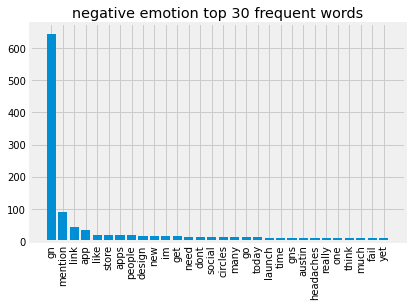

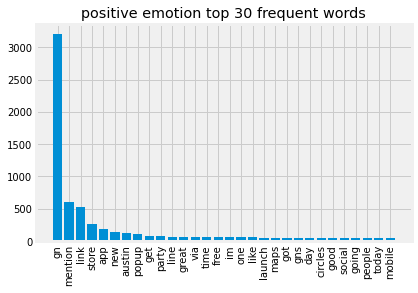

In [20]:
plt.bar(top30_neg.keys(), top30_neg.values())
plt.xticks(rotation = 90)
plt.title('negative emotion top 30 frequent words')
plt.show()

plt.bar(top30_pos.keys(), top30_pos.values())
plt.xticks(rotation = 90)
plt.title('positive emotion top 30 frequent words')
plt.show()

### TF-IDF Score

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(ngram_range=(1, 2), min_df = 2, stop_words = sw)
tf_X_train = tf.fit_transform(X_train_pp['tweet'])
tf_X_val = tf.transform(X_val_pp['tweet'])
tf_X_test = tf.transform(X_test_pp['tweet'])

In [22]:
tf_X_train = pd.DataFrame(tf_X_train.todense(), index=X_train_pp.index)
tf_X_val = pd.DataFrame(tf_X_val.todense(), index=X_val_pp.index)
tf_X_test = pd.DataFrame(tf_X_test.todense(), index=X_test_pp.index)

In [23]:
X_train_fin = X_train_pp.join(tf_X_train)
X_val_fin = X_val_pp.join(tf_X_val)
X_test_fin = X_test_pp.join(tf_X_test)

### Average Word Vectors

In [24]:
from gensim.models import word2vec

In [25]:
# building GloVe dictionary
glove_path = '/Users/stereopickles/Documents/GloVe/glove.twitter.27B/glove.twitter.27B.50d.txt'
glove_dict = {}
with open(glove_path, 'r', encoding = 'utf-8') as f:
    for line in f:
        vals = line.split(' ')
        glove_dict[vals[0]] = np.asarray(vals[1:], dtype = 'float32')

In [42]:
X_train_tweet = X_train_fin.tweet.apply(lambda x: tokenize(x, sw))
X_val_tweet = X_val_fin.tweet.apply(lambda x: tokenize(x, sw))
X_test_tweet = X_test_fin.tweet.apply(lambda x: tokenize(x, sw))

In [43]:
# calculate the average word vector
def get_mean_vector(list_):
    veclist = [glove_dict[x] for x in list_ if x in glove_dict]
    if veclist: return np.mean(veclist)
    else: return 0

In [44]:
X_train_mean_vec = X_train_tweet.apply(lambda x: get_mean_vector(x))
X_val_mean_vec = X_val_tweet.apply(lambda x: get_mean_vector(x))
X_test_mean_vec = X_test_tweet.apply(lambda x: get_mean_vector(x))

In [49]:
X_train_fin['mean_vec'] = X_train_mean_vec
X_val_fin['mean_vec'] = X_val_mean_vec
X_test_fin['mean_vec'] = X_test_mean_vec

## Export Pickles
Export preprocessed data out as pickles

In [50]:
#import os
#os.mkdir('PKL')

In [51]:
X_train_fin.to_pickle('PKL/X_train_fin.pkl')
X_val_fin.to_pickle('PKL/X_val_fin.pkl')
X_test_fin.to_pickle('PKL/X_test_fin.pkl')